In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [13]:
def cargar_datos(
        ruta:str,
        sample:bool,
        columns:list,
        percent:float
        ):
    df = pd.read_csv(ruta, sep=',')
    
    if sample:
        df = df.sample(frac=percent, random_state=42)
    
    df = df[columns]

    return df

# Formatear el UNK a NaN cuando sean 3 valores, y los otros dos sean True o False
def cambiar_UNK_a_nan(df:pd.DataFrame):
    pd.set_option('future.no_silent_downcasting', True) 
    
    columnas = [col for col in df.columns.tolist() if df[col].dtype == 'object']
    col_con_UNK = [col for col in columnas if df[col].astype(str).str.contains('UNK').any()]
    col_TF = [x for x in columnas if set(df[x].dropna().unique()) == {'True', 'False',}]
    col_hat_true_false = list(set(col_con_UNK + col_TF))
    
    # convertir las columnas de UNK a NaN
    for col in col_hat_true_false:
        df.loc[:, col] = df[col].replace({'UNK': np.nan, 'True': True, 'False': False})
    return df


# Función que transforma las columnas de True y False a 1 y 0    
def transf_true_false(df:pd.DataFrame):
    columnas = df.columns.tolist()
    # quiero poner en columnas booleanas los valores que son True y False en 1 y 0, validando que sean o True o False, donde los NaN no se consideran
    col_true_false = [x for x in columnas if (df[x].dtype == 'object' or df[x].dtype == 'bool') and (set(df[x].dropna().unique()) == {True, False,})]
    # convertir las columnas de True y False a 1 y 0
    for col in col_true_false:
        df[col] = df[col].map({True: 1, False: 0})
    return df

In [15]:
# leer sólo las columnas de los archivos que podríamos van a utilizar
ruta_cancer = 'metadatos.csv'
col_c = pd.read_csv(ruta_cancer, nrows=0, sep=',').columns.to_list()
print(f'Columnas de cancer: {col_c}')

# Vamos a usar las columnas del archivo de cancer, y sólo voy a usar estas columnas, pq no necesito 'patient_id', 'lesion_id','img_id'
columns = ['smoke', 'drink', 'background_father', 'background_mother', 'age', 'pesticide', 'gender', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick', 'region', 'diameter_1', 'diameter_2', 'diagnostic', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation', 'biopsed']

df = cargar_datos(ruta=ruta_cancer, sample=True, columns=columns, percent=0.50)

Columnas de cancer: ['patient_id', 'lesion_id', 'smoke', 'drink', 'background_father', 'background_mother', 'age', 'pesticide', 'gender', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick', 'region', 'diameter_1', 'diameter_2', 'diagnostic', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation', 'img_id', 'biopsed']


In [16]:
df = cambiar_UNK_a_nan(df) # convertir los valores de UNK a NaN y a True y False booleanos
df = transf_true_false(df)  # transformar las columnas de True y False a 1 y 0
# Función de apoyo para obtener los valores únicos y % de nulos de un dataframe para eligir las columnas que quiero
def obtener_analisis(df:pd.DataFrame):
    unicos = {}
    for col in df.columns.tolist():
        lista_unique = df[col].unique().tolist()
        unicos[col] = lista_unique

    porc_nulos = {}
    for col in df.columns.tolist():
        nulo = df[col].isnull().sum()
        porc_nulos[col] = round(float(nulo/df.shape[0]), 2)
   
    datos_analisis = {
                     'Columna': list(unicos.keys()),
                     'Valor único': list(unicos.values()),	
                     'Porcentaje nulos': list(porc_nulos.values())
                     }
    df_datos = pd.DataFrame(datos_analisis)
    return df_datos

df_analisis = obtener_analisis(df)
df_analisis

,Columna,Valor único,Porcentaje nulos
0,smoke,"[nan, 0.0, 1.0]",0.33
1,drink,"[nan, 0.0, 1.0]",0.33
2,background_father,"[nan, POMERANIA, GERMANY, ITALY, BRAZIL, NETHE...",0.39
3,background_mother,"[nan, POMERANIA, GERMANY, ITALY, BRAZIL, FRANC...",0.38
4,age,"[39, 58, 56, 71, 79, 85, 46, 61, 78, 83, 80, 5...",0.00
5,pesticide,"[nan, 1.0, 0.0]",0.33
6,gender,"[nan, FEMALE, MALE]",0.33
7,skin_cancer_history,"[nan, 1.0, 0.0]",0.33
8,cancer_history,"[nan, 1.0, 0.0]",0.33
9,has_piped_water,"[nan, 0.0, 1.0]",0.33


In [19]:
from sklearn.preprocessing import LabelEncoder

# Codificar las columnas categóricas de mi target diagnostic
def codificar_label_encoder(df:pd.DataFrame, col_target:str):
    encoder = LabelEncoder()
    new_col = f"{col_target}_encoded"
    df[new_col] = encoder.fit_transform(df[col_target])
    lista_categorias = encoder.classes_  #  lista ordenada de las clases únicas encontradas en el descriptor ordenadas alfabéticamente igual q el unique() pero ordenado
    lista_num = encoder.transform(encoder.classes_)
    dic_categ_num = dict(zip(lista_categorias, lista_num))
    dic_categ_num = {k: int(v) for k, v in dic_categ_num.items()}
    return df, dic_categ_num, new_col

df, label_num, col_encoded_target = codificar_label_encoder(df, 'diagnostic')
print(f'Columna codificada: {col_encoded_target}')
print(f'Label codificado: {label_num}')

df.dtypes

Columna codificada: diagnostic_encoded
Label codificado: {'ACK': 0, 'BCC': 1, 'MEL': 2, 'NEV': 3, 'SCC': 4, 'SEK': 5}


smoke                  float64
drink                  float64
background_father       object
background_mother       object
age                      int64
pesticide              float64
gender                  object
skin_cancer_history    float64
cancer_history         float64
has_piped_water        float64
has_sewage_system      float64
fitspatrick            float64
region                  object
diameter_1             float64
diameter_2             float64
diagnostic              object
itch                     int64
grew                   float64
hurt                   float64
changed                float64
bleed                  float64
elevation              float64
biopsed                  int64
diagnostic_encoded       int64
dtype: object

In [18]:
def diagnositico_estadistico(descriptor, media:bool=False, desv:bool=False, perdidos:bool=False ,max:bool=False , min:bool=False, redondear:int=2, del_NaN:bool=False) -> dict:
# por defecto están todos seteados en False
    respuesta = {}
    # consulto primero por los valores perdidos, es decir, los NaN
    if perdidos:
        respuesta['perdidos'] = int(np.sum(descriptor.isnull()))
    
    # eliminar si hay valores Nan
    if del_NaN:
        d = descriptor.dropna()
    else:
        d = descriptor

    if media:
        respuesta['media'] = float(d.mean().round(redondear))
    if desv:
        respuesta['desviacion'] = float(d.std().round(redondear))
    if max:
        respuesta['maximo'] = float(d.max().round(redondear))
    if min:
        respuesta['minimo'] = float(d.min().round(redondear))
    
    return respuesta

# sólo voy a obtener los valores estadísticos de las columnas numéricas
lista_col_numerico = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
res_stat = {}
for col in lista_col_numerico:
    d = df[col]
    diag_stat = diagnositico_estadistico(d, media=True, desv=True, perdidos=True, max=True, min=True, redondear=2, del_NaN=True)
    res_stat[col] = diag_stat
df_stat = pd.DataFrame(res_stat)
df_stat

,smoke,drink,age,pesticide,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,diameter_1,diameter_2,itch,grew,hurt,changed,bleed,elevation,biopsed,diagnostic_encoded
perdidos,383.00,383.00,0.00,383.00,383.00,383.00,383.00,383.00,383.00,383.00,383.00,0.00,209.00,6.00,209.0,3.00,1.00,0.00,0.00
media,0.13,0.26,60.95,0.39,0.46,0.51,0.62,0.58,2.29,12.34,9.21,0.63,0.48,0.18,0.1,0.28,0.63,0.59,1.59
desviacion,0.34,0.44,15.41,0.49,0.50,0.50,0.48,0.49,0.75,9.22,6.43,0.48,0.50,0.38,0.3,0.45,0.48,0.49,1.68
maximo,1.00,1.00,94.00,1.00,1.00,1.00,1.00,1.00,6.00,100.00,70.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,5.00
minimo,0.00,0.00,6.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00


In [29]:
import yaml

def cargar_datos_yaml(ruta:str, new_data):
    # cargar los datos existentes en el archivo YAML
    try:
        with open('datos_guardados.yaml', 'r') as file:
            antiguo_dict = yaml.safe_load(file)
            if antiguo_dict is None:
                antiguo_dict = {}
    except FileNotFoundError:
        antiguo_dict = {}
    
    antiguo_dict.update(new_data)

    # guardar el nuevo dato en archivo YAML
    with open('datos_guardados.yaml', 'w') as file:
        yaml.dump(antiguo_dict, file, default_flow_style=False, allow_unicode=True)

# columna_selec = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# todas_columnas = {"columna_selec": columna_selec}
# cargar_datos_yaml('data/datos_guardados.yaml', todas_columnas)

In [30]:
def separar_datos_yaml(ruta:str, col:str):
    with open(ruta, 'r') as file:
        datos = yaml.safe_load(file)
    datos_imputar = datos[col] # lista de dict

    clave = []
    valores = []

    for valor in datos_imputar:
        for key, value in valor.items():  # Iterar sobre cada diccionario
            clave.append(key)
            valores.append(value)
    return clave, valores

In [31]:
def imputar_datos(df:pd.DataFrame, lista_col:list, estrategias:list) -> pd.DataFrame:
    df_copy = df.copy()
    for col, estrategia in zip(lista_col, estrategias):
        if estrategia == 'most_frequent':
            df_copy[col] = df_copy[col].fillna(df_copy[col].mode()[0])
        elif estrategia == 'mean':
            df_copy[col] = df_copy[col].fillna(df_copy[col].mean().round(2))
        elif estrategia == 'median':
            df_copy[col] = df_copy[col].fillna(df_copy[col].median().round(2))
        elif estrategia == 'constant_zero':
            df_copy[col] = df_copy[col].fillna(0)
        elif estrategia == 'dropna':
            df_copy[col] = df_copy[col].dropna()    
        # imputar = SimpleImputer(strategy=estrategia)
        # df_copy[col] = imputar.fit_transform(df_copy[[col]]) # me causa muchos problemas
    
    return df_copy

# cargar los datos de las columnas que tienen valores nulos
col_a_imputar, estrategia = separar_datos_yaml('datos_guardados.yaml', 'Col_imputar')

df_imputado = imputar_datos(df, col_a_imputar, estrategia)

df_analisis_imputado = obtener_analisis(df_imputado)
df_analisis_imputado

FileNotFoundError: [Errno 2] No such file or directory: 'datos_guardados.yaml'

NameError: name 'df_imputado' is not defined

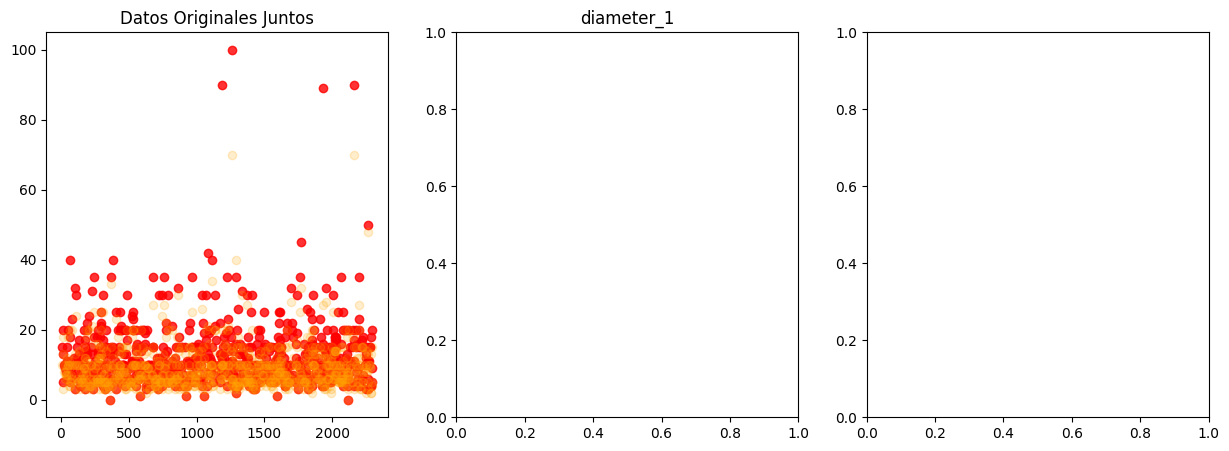

In [23]:
# graficar la distribución de los datos antes y después de la imputación
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.set_title("Datos Originales Juntos")
ax1.plot(df['diameter_1'], linewidth=0, marker="o", color="red", alpha=0.8, markersize=6)
ax1.plot(df['diameter_2'], linewidth=0, marker="o", color="orange", alpha=0.2, markersize=6)

ax2.set_title("diameter_1")
ax2.plot(df_imputado["diameter_1"], linewidth=0, marker="o", color="blue", markersize=6)

ax3.set_title("diameter_2")
ax3.plot(df_imputado["diameter_2"], linewidth=0, marker="+", color="green", markersize=16)
plt.show()

In [32]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# sólo voy a obtener los valores estadísticos de las columnas numéricas
lista_col_numerico = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(lista_col_numerico)
# lo que quiero graficar lo trasformo en DataFrames
df_graficar = df_imputado[lista_col_numerico]
# normalizar los datos de las columnas numéricas, usando el df imputado
datos_min_max = MinMaxScaler().fit_transform(df_graficar)
datos_standard_scaler = StandardScaler().fit_transform(df_graficar)

# convierte vectores de numpy a DataFrames para graficarlos
df_min_max = pd.DataFrame(datos_min_max, columns=[lista_col_numerico])
df_standard_scaler = pd.DataFrame(datos_standard_scaler, columns=[lista_col_numerico])

def graficar_histogramas(df_graf:pd.DataFrame, df_min_max:pd.DataFrame, df_standard_scaler:pd.DataFrame, col_a_graficar:str, color_graf:str):
    
    # crea una figura con 3 subfiguras para mostrar histogramas
    fig = plt.figure(figsize=(15, 3))
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)
    # crea y personaliza series de datos de los histogramas
    ax1.set_title(col_a_graficar)
    ax1.hist(df_graf[col_a_graficar], color=color_graf, bins=50)

    ax2.set_title("Escalar Min Max " + col_a_graficar)
    ax2.hist(df_min_max[col_a_graficar], color=color_graf, bins=50)

    ax3.set_title("Standard Scaler " + col_a_graficar)
    ax3.hist(df_standard_scaler[col_a_graficar], color=color_graf, bins=50)
    plt.show()
    
graficar_histogramas(df_graficar, df_min_max, df_standard_scaler, 'diameter_1', 'red')
graficar_histogramas(df_graficar, df_min_max, df_standard_scaler, 'diameter_2', 'green')
graficar_histogramas(df_graficar, df_min_max, df_standard_scaler, 'fitspatrick', 'blue')

['smoke', 'drink', 'age', 'pesticide', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick', 'diameter_1', 'diameter_2', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation', 'biopsed', 'diagnostic_encoded']


NameError: name 'df_imputado' is not defined

In [ ]:
def graficar_boxplot(descriptor, max_min, std_scaler, col_a_graficar:str):
    # crea una figura con 3 subfiguras para mostrar boxplots
    fig = plt.figure(figsize=(15, 3))
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)
    
    ax1.set_title(f"Boxplot de {col_a_graficar}")
    ax1.boxplot(descriptor)
    
    ax2.set_title("Boxplot de Min Max")
    ax2.boxplot(max_min)
    
    ax3.set_title("Boxplot de Standard Scaler")
    ax3.boxplot(std_scaler)
    plt.show()
    
graficar_boxplot(df_graficar['age'], df_min_max['age'], df_standard_scaler['age'], 'age')

In [ ]:
def graficar_torta(descriptor1, descriptor2, col:str):
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    
    ax1.set_title(f"Original {col}")
    ax1.text(0, -1.3, f'Total: {descriptor1.count()}', ha='center', fontsize=12)
    descriptor1.value_counts().plot.pie(autopct='%1.1f%%', ax=ax1)
    
    ax2.set_title(f"Imputado {col}")
    ax2.text(0, -1.3, f'Total: {descriptor2.count()}', ha='center', fontsize=12)
    descriptor2.value_counts().plot.pie(autopct='%1.1f%%', ax=ax2)
    
    plt.show()

# graficar_torta(df, df_imputado, 'cancer_history')
graficar_torta(df['skin_cancer_history'], df_imputado['skin_cancer_history'], 'skin_cancer_history')
# graficar_torta(df, df_imputado, 'changed')

In [ ]:
def graficar_plot_bloxplot(descriptor1, descriptor2, tipo_grafico, guardar:bool=False, titulo:str=None):
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    
    if tipo_grafico == 'plot':
        ax1.set_title(f"Gráfico_{tipo_grafico} {titulo}")
        sns.lineplot(data=descriptor1, ax=ax1, linewidth=0, marker="o", color="red", alpha=0.8, markersize=6)

        ax2.set_title(f"Gráfico_{tipo_grafico} {titulo}")
        sns.lineplot(data=descriptor2, ax=ax2, linewidth=0, marker="o", color="red", alpha=0.8, markersize=6)
        
    if tipo_grafico == 'bloxplot':
        
        ax1.set_title(f"Gráfico_{tipo_grafico} {titulo}")
        sns.boxplot(data=descriptor1, ax=ax1)
        
        ax2.set_title(f"Gráfico_{tipo_grafico} {titulo}")
        sns.boxplot(data=descriptor2, ax=ax2)
    
    if guardar:
        if not os.path.exists('graficos'):
            os.makedirs('graficos')
        plt.savefig(f'graficos/grafico_{tipo_grafico}_{titulo}.png')
    plt.show()
    
    
graficar_plot_bloxplot(df['age'], df_imputado['age'], 'bloxplot', guardar=True, titulo='age')
graficar_plot_bloxplot(df['age'], df_imputado['age'], 'plot', guardar=True, titulo='age')
graficar_plot_bloxplot(df['diameter_1'], df['diameter_2'], 'plot', guardar=True, titulo='diameter_1_vs_diameter_2')
graficar_plot_bloxplot(df_imputado['diameter_1'], df_imputado['diameter_2'], 'plot', guardar=True, titulo='diameter_1_vs_diameter_2_imputado')
graficar_plot_bloxplot(df['fitspatrick'], df_imputado['fitspatrick'], 'bloxplot', guardar=True, titulo='fitspatrick')

In [ ]:
def normalizacion_datos(df:pd.DataFrame, tipo_normalizacion:str):
    columnas = df.columns.tolist()
    if tipo_normalizacion == 'MinMax':
        datos_normalizados = MinMaxScaler().fit_transform(df)
    elif tipo_normalizacion == 'StandardScaler':
        datos_normalizados = StandardScaler().fit_transform(df)
    
    # convierte vectores de numpy a DataFrames
    df_result= pd.DataFrame(datos_normalizados, columns=[columnas])
    return df_result

df_datos_a_normalizar = df_graficar[['diameter_1', 'diameter_2', 'age', 'fitspatrick']]
df_MinMax = normalizacion_datos(df_datos_a_normalizar, 'MinMax')
df_StandardScaler = normalizacion_datos(df_datos_a_normalizar, 'StandardScaler')

In [ ]:
def generar_train_test(df:pd.DataFrame, col_target:str, del_col:list, rand_st:int, test_tam:float):
    X = df_imputado.drop(del_col, axis=1)
    y = df_imputado[col_target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_tam, random_state=rand_st)
    return X_train, X_test, y_train, y_test

col_eliminar = ['diagnostic', 'diagnostic_encoded', 'biopsed', 'background_father', 'background_mother', 'gender']
random_state = 19
X_train, X_test, y_train, y_test = generar_train_test(df_imputado, 'diagnostic_encoded', col_eliminar, random_state, 0.2)

In [ ]:
# tengo un problema con este perfomance warning del df.drop(columns..) asi que lo voy a ignorar, son solo 3 drops
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [ ]:
class Preprocesamiento:
    def __init__(self, ruta:str, muestra:bool, columnas:list, sep:str, nombre_col_y:str, rand_state_sample, porcentaje:float=0.5, ruta_config:str='data/datos_guardados.yaml'):
        self.ruta = ruta
        self.muestra = muestra
        self.columnas = columnas
        self.sep = sep
        self.rand_state_sample = rand_state_sample
        self.porcentaje = porcentaje
        self.ruta_config = ruta_config
        self.nombre_col_y = nombre_col_y
        self._df = None

    def cargar_datos(self):
        if not os.path.exists(self.ruta):
            raise FileNotFoundError(f'No se encontró el archivo en la ruta: {self.ruta}')
        df = pd.read_csv(self.ruta, sep=self.sep)
        if self.muestra:
            df = df.sample(frac=self.porcentaje, random_state=self.rand_state_sample)
        df_final = df[self.columnas]
        return df_final
        
            
    def cambiar_UNK_a_nan(self, df:pd.DataFrame):
        pd.set_option('future.no_silent_downcasting', True) # para que no muestre el warning de que se va a eliminar en futuras versiones
        
        columnas = [col for col in df.columns.tolist() if df[col].dtype == 'object']
        col_con_UNK = [col for col in columnas if df[col].astype(str).str.contains('UNK').any()]
        col_TF = [x for x in columnas if set(df[x].dropna().unique()) == {'True', 'False',}]
        col_hat_true_false = list(set(col_con_UNK + col_TF))

        for col in col_hat_true_false:
            df.loc[:, col] = df[col].replace({'UNK': np.nan, 'True': True, 'False': False})
        
        return df
    
    def transf_true_false(self, df:pd.DataFrame):
        columnas = df.columns.tolist()
        col_true_false = [x for x in columnas if (df[x].dtype == 'object' or df[x].dtype == 'bool') and (set(df[x].dropna().unique()) == {True, False,})]
        for col in col_true_false:
            df[col] = df[col].map({True: 1, False: 0})
            df[col] = df[col].infer_objects(copy=False)
        return df
    
    # función de apoyo para ver valores únicos y % de nulos de un dataframe
    def obtener_analisis(self, df:pd.DataFrame):
        unicos = {}
        for col in df.columns.tolist():
            lista_unique = df[col].unique().tolist()
            unicos[col] = lista_unique

        porc_nulos = {}
        for col in df.columns.tolist():
            nulo = df[col].isnull().sum()
            porc_nulos[col] = round(float(nulo/df.shape[0]), 2)
        
        datos_analisis = {
                        'Columna': list(unicos.keys()),
                        'Valor único': list(unicos.values()),	
                        'Porcentaje nulos': list(porc_nulos.values()), 
                        }
        df_datos = pd.DataFrame(datos_analisis)
        return df_datos
    
    def separar_datos_yaml(self, col:str):
        with open(self.ruta_config, 'r') as file:
            datos = yaml.safe_load(file)
        datos_imputar = datos[col] # lista de dict
        clave = []
        valores = []
        for valor in datos_imputar:
            for key, value in valor.items():  # Iterar sobre cada diccionario dentro de la lista
                clave.append(key)
                valores.append(value)
        return clave, valores
    
    def codificar_label_encoder(self, df: pd.DataFrame):
        encoder = LabelEncoder()
        new_col = f"{self.nombre_col_y}_encoded"
        df[new_col] = encoder.fit_transform(df[self.nombre_col_y])
        df = df.drop(columns=self.nombre_col_y)
        lista_label = encoder.classes_
        lista_num = encoder.transform(encoder.classes_)
        label_num = dict(zip(lista_label, lista_num))
        label_num = {k: int(v) for k, v in label_num.items()}
        
        return df, label_num, new_col
    
    # tengo que poner los setters y getters de self._df, aproveche de poner las funciones de cargar_datos, cambiar_UNK_a_nan y transf_true_false    
    @property
    def df(self):
        if self._df is None:
            df_ = self.cargar_datos()
            df_ = self.cambiar_UNK_a_nan(df_)
            df_ = self.transf_true_false(df_)
            self._df = df_
        return self._df

    @df.setter
    def df(self, value):
        self._df = value    
        
    
    def diagnositico_estadistico(self, descriptor, media:bool=False, desv:bool=False, perdidos:bool=False ,max:bool=False , min:bool=False, redondear:int=2, del_NaN:bool=True) -> dict:
    # por defecto están todos seteados en False
        respuesta = {}
        # consulto primero por los valores perdidos, es decir, los NaN
        if perdidos:
            respuesta['perdidos'] = int(np.sum(descriptor.isnull()))
        
        # eliminar si hay valores Nan
        if del_NaN:
            d = descriptor.dropna()
        else:
            d = descriptor

        if media:
            respuesta['media'] = float(d.mean().round(redondear))
        if desv:
            respuesta['desviacion'] = float(d.std().round(redondear))
        if max:
            respuesta['maximo'] = float(d.max().round(redondear))
        if min:
            respuesta['minimo'] = float(d.min().round(redondear))
        
        return respuesta
    
    def imputar_datos(self, df:pd.DataFrame, lista_col:list, estrategias:list) -> pd.DataFrame:
        df_copy = df.copy()
        for col, estrategia in zip(lista_col, estrategias):
            if estrategia == 'most_frequent':
                df_copy[col] = df_copy[col].fillna(df_copy[col].mode()[0])
            elif estrategia == 'mean':
                df_copy[col] = df_copy[col].fillna(df_copy[col].mean().round(2))
            elif estrategia == 'median':
                df_copy[col] = df_copy[col].fillna(df_copy[col].median().round(2))
            elif estrategia == 'constant_zero':
                df_copy[col] = df_copy[col].fillna(0)
            elif estrategia == 'dropna':
                df_copy[col] = df_copy[col].dropna()    
        return df_copy

    def normalizacion_datos(self, df:pd.DataFrame, tipo_normalizacion:str):
        columnas = df.columns.tolist()
        if tipo_normalizacion == 'MinMax':
            datos_normalizados = MinMaxScaler().fit_transform(df)
        elif tipo_normalizacion == 'StandardScaler':
            datos_normalizados = StandardScaler().fit_transform(df)
        # convierte vectores de numpy a DataFrames
        df_result= pd.DataFrame(datos_normalizados, columns=[columnas])
        return df_result
    
    def generar_train_test(self, df, col_target:str, rand_st:int, test_tam:float):
        X = df.drop(col_target, axis=1)
        y = df[col_target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_tam, random_state=rand_st)
        return X_train, X_test, y_train, y_test
    
    
    def graficar_histogramas(self, df_graf:pd.DataFrame, df_graf2:pd.DataFrame, df_graf3:pd.DataFrame, col_a_graficar:list, color_graf:str):
    
        # crea una figura con 3 subfiguras para mostrar histogramas
        fig = plt.figure(figsize=(15, 3))
        ax1 = fig.add_subplot(1, 3, 1)
        ax2 = fig.add_subplot(1, 3, 2)
        ax3 = fig.add_subplot(1, 3, 3)
        # crea y personaliza series de datos de los histogramas
        ax1.set_title(col_a_graficar[0].capitalize())
        ax1.hist(df_graf[col_a_graficar[0]], color=color_graf, bins=50)

        ax2.set_title(col_a_graficar[1].capitalize())
        ax2.hist(df_graf2[col_a_graficar[1]], color=color_graf, bins=50)

        ax3.set_title(col_a_graficar[2].capitalize())
        ax3.hist(df_graf3[col_a_graficar[2]], color=color_graf, bins=50)
        plt.show()
   
    def graficar_boxplot(self, descriptor, max_min, std_scaler, col_a_graficar:str):
        # crea una figura con 3 subfiguras para mostrar boxplots
        fig = plt.figure(figsize=(15, 3))
        ax1 = fig.add_subplot(1, 3, 1)
        ax2 = fig.add_subplot(1, 3, 2)
        ax3 = fig.add_subplot(1, 3, 3)
        
        ax1.set_title(f"Boxplot de {col_a_graficar}")
        ax1.boxplot(descriptor)
        
        ax2.set_title("Boxplot de Min Max")
        ax2.boxplot(max_min)
        
        ax3.set_title("Boxplot de Standard Scaler")
        ax3.boxplot(std_scaler)
        plt.show()
    
    def graficar_torta(self, descriptor1, descriptor2, titulo:list):
        fig = plt.figure(figsize=(10, 5))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)
        
        ax1.set_title(titulo[0].capitalize())
        ax1.text(0, -1.3, f'Total: {descriptor1.count()}', ha='center', fontsize=12)
        descriptor1.value_counts().plot.pie(autopct='%1.1f%%', ax=ax1)
        
        ax2.set_title(titulo[1].capitalize())
        ax2.text(0, -1.3, f'Total: {descriptor2.count()}', ha='center', fontsize=12)
        descriptor2.value_counts().plot.pie(autopct='%1.1f%%', ax=ax2)
        
        plt.show()
    
    def graficar_plot_bloxplot(self, descriptor1, descriptor2, tipo_grafico, guardar:bool=False, titulo:str=None):
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)
        
        if tipo_grafico == 'plot':
            ax1.set_title(f"Gráfico_{tipo_grafico} {titulo}")
            sns.lineplot(data=descriptor1, ax=ax1, linewidth=0, marker="o", color="red", alpha=0.8, markersize=6)

            ax2.set_title(f"Gráfico_{tipo_grafico} {titulo}")
            sns.lineplot(data=descriptor2, ax=ax2, linewidth=0, marker="o", color="red", alpha=0.8, markersize=6)
            
        if tipo_grafico == 'bloxplot':
            
            ax1.set_title(f"Gráfico_{tipo_grafico} {titulo}")
            sns.boxplot(data=descriptor1, ax=ax1)
            
            ax2.set_title(f"Gráfico_{tipo_grafico} {titulo}")
            sns.boxplot(data=descriptor2, ax=ax2)
        
        if guardar:
            if not os.path.exists('graficos'):
                os.makedirs('graficos')
            plt.savefig(f'graficos/grafico_{tipo_grafico}_{titulo}.png')
        plt.show()
        
    ### Ejecutar el procesamiento de los datos 
    def ejecutar_procesamiento(self, col_a_imputar_in_file, tipo_escalado, normalizar:bool=True, eliminar_col=None):
        self.cargar_datos()
        df = self.df
        
        if eliminar_col is not None:
            df = df.drop(columns=eliminar_col) # elimino las columnas que no quiero procesar
                
        # armo el labelEncoder de la columna target 
        df_encoder, dict_clase_num, nombre_col_y_cod= self.codificar_label_encoder(df)
        
        
        col_a_imputar, estrategia = self.separar_datos_yaml(col_a_imputar_in_file) # lo dejé en un archivo yaml con las columnas a imputar y la estrategia
        if eliminar_col is not None:
            col_a_imputar = [col for col in col_a_imputar if col not in eliminar_col] # de aquí también elimino las columnas que no quiero imputar pq ya las eliminé arriba.
                      
        df_imputado = self.imputar_datos(df_encoder, col_a_imputar, estrategia)
        # no quiero normalizar si uso logistic regression o Naive Bayes
        if normalizar:
            df_datos_a_normalizar = self.normalizacion_datos(df_imputado, tipo_escalado)
        else:
            df_datos_a_normalizar = df_imputado
        
        return df_datos_a_normalizar, dict_clase_num, nombre_col_y_cod
    
    def calcular_prior_clase(self, df:pd.DataFrame, col_target:str):
        if df[col_target].count() == 0:
            raise ValueError('No hay datos en la columna target')
        pd_prior = df[col_target].value_counts() / df[col_target].count()
        return pd_prior

In [ ]:
ruta_datos = 'data/metadatos.csv'
columnas_a_usar = ['smoke', 'drink', 'background_father', 'background_mother', 'age', 'pesticide', 'gender', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick', 'region', 'diameter_1', 'diameter_2', 'diagnostic', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation', 'biopsed']
col_clase = 'diagnostic'
ruta_config_yaml = 'data/datos_guardados.yaml'
col_a_imputar_in_file ='Col_imputar'
tipo_escalado = 'StandardScaler'
porcentaje_muestra = 0.5
porc_test = 0.3
rand_state_muestra=42
rand_state_test=42
# no quiero normalizar si uso logistic regression o Naive Bayes, por eso eliminé las columnas que no quiero procesar pq son no categoricas
eliminar_col = ['biopsed', 'background_father', 'background_mother', 'age','gender','region','fitspatrick','diameter_1', 'diameter_2', 'bleed', 'elevation']
normalizado = False


preproc = Preprocesamiento(ruta=ruta_datos, muestra=True, columnas=columnas_a_usar, sep=',', nombre_col_y=col_clase, rand_state_sample = rand_state_muestra, porcentaje=porcentaje_muestra, ruta_config=ruta_config_yaml)

df_imputado, dict_clase_num, nombre_col_y_cod = preproc.ejecutar_procesamiento(col_a_imputar_in_file, tipo_escalado, normalizado, eliminar_col)

X_train, X_test, y_train, y_test = preproc.generar_train_test(df_imputado, nombre_col_y_cod, rand_state_test, porc_test)

print(f'La codificación de la clase {col_clase} es: {dict_clase_num}')
print(f'Nombre de la columna codificada: {nombre_col_y_cod}')
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'{preproc.df.shape}')
preproc.obtener_analisis(preproc.df)

In [ ]:
df_y_prior = preproc.calcular_prior_clase(df_imputado, nombre_col_y_cod)
df_y_prior

In [ ]:
# graficar torta de algo booleano, ver la imputación con la estratia, como cambiaron los datos
col_a_graf = ['skin_cancer_history', 'cancer_history']
estrategias = ['most_frequent', 'most_frequent']
titulo_0 = [col_a_graf[0],f'{col_a_graf[0]}_imputado']
titulo_1 = [col_a_graf[1],f'{col_a_graf[1]}_imputado']
df = preproc.df
df_imputado = preproc.imputar_datos(df, col_a_graf, estrategias)
preproc.graficar_torta(df[col_a_graf[0]], df_imputado[col_a_graf[0]], titulo_0)
preproc.graficar_torta(df[col_a_graf[1]], df_imputado[col_a_graf[1]], titulo_1)

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import joblib
import datetime

def clasificador(tipo_clasif: str, subcarpeta: str, X_train, y_train, max_iter_RL=None, priors_nb=None):
    if tipo_clasif == 'naive_bayes':
        modelo = GaussianNB(priors=priors_nb)
        
    elif tipo_clasif == 'logistic_regression':
        modelo = LogisticRegression(max_iter=max_iter_RL)
        
    else:
        raise ValueError("Favor sólo ingrese estos datos: naive_bayes o logistic_regression.")

    # entrenar el modelo
    modelo.fit(X_train, y_train)

    # guardar el modelo en una ruta... tuve que poner la fecha pq me estaban sobreescribiendo los modelos
    fecha = datetime.datetime.now().strftime("%y-%m-%d_%f")
    
    ruta_guardar = f'{subcarpeta}/{fecha}_{tipo_clasif}_model.pkl'
    # if os.path.exists(ruta_guardar):
    #     os.remove(ruta_guardar)
    joblib.dump(modelo, ruta_guardar)
    print(f"el modelo se guardo en: {ruta_guardar}")
    return ruta_guardar
fecha = datetime.datetime.now().strftime("%y-%m-%d_%f")
fecha

In [ ]:
ruta_modelo = clasificador('naive_bayes', 'models', X_train, y_train)
modelo_ng = joblib.load(ruta_modelo)
modelo_ng.theta_

In [ ]:
ruta_modelo = clasificador('logistic_regression', 'models', X_train, y_train, 1000)
modelo_lg = joblib.load(ruta_modelo)
modelo_lg.coef_

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

def evaluar_rendimiento(ruta_modelo, tipo_analisis, X_test, y_test):
    # Recargar modelos
    modelo = joblib.load(ruta_modelo)
    if tipo_analisis == 'matriz_confusion':
        y_pred = modelo.predict(X_test)
        matriz_confusion = confusion_matrix(y_test, y_pred)
        return matriz_confusion
    
    elif tipo_analisis == 'metricas_evaluacion':
        metricas = {}
        y_pred = modelo.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        metricas['accuracy'] = accuracy
        recall = recall_score(y_test, y_pred, average='weighted')  
        metricas['recall'] = recall
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0) # en la doc dice: weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). 
        metricas['precision'] = precision
        f1 = f1_score(y_test, y_pred, average='weighted')
        metricas['f1_score'] = f1
        return metricas
        
    else:
        raise ValueError("Favor sólo ingrese estos datos: matriz_confusion o metricas_evaluacion.")

In [ ]:
nb_ruta_modelo = clasificador('naive_bayes', 'models', X_train, y_train)
nb_modelo = joblib.load(nb_ruta_modelo)

df_y_prior = preproc.calcular_prior_clase(df_imputado, nombre_col_y_cod)
_y_prior = df_y_prior.to_numpy()
print(f'Calculo a priori de la clase y: {_y_prior}')

probabilidad_prior = nb_modelo.class_prior_
print(f'Probabilidad a priori: {probabilidad_prior}')

nb_metrics = evaluar_rendimiento(nb_ruta_modelo, 'metricas_evaluacion', X_test, y_test)
pd_nb_metrics = pd.DataFrame(nb_metrics, index=['Naive_Bayes'])

nb_ruta_modelo_y = clasificador('naive_bayes', 'models', X_train, y_train, priors_nb=_y_prior)
nb_modelo_y = joblib.load(nb_ruta_modelo_y)
nb_metrics_y = evaluar_rendimiento(nb_ruta_modelo_y, 'metricas_evaluacion', X_test, y_test)
pd_nb_metrics_y = pd.DataFrame(nb_metrics_y, index=['Naive_Bayes_y'])

# ahora puedo concatenar los dos dataframes y ver las métricas de los dos modelos 
pd_nb_metrics_comb = pd.concat([pd_nb_metrics, pd_nb_metrics_y])
pd_nb_metrics_comb

In [ ]:
def obtener_datos_penalty(ruta_config_yaml:str, nombre_variable:str, nombre_penalty:str):
    with open(ruta_config_yaml, "r") as file:
        yaml_file = yaml.safe_load(file)
    alphas = yaml_file[nombre_variable][nombre_penalty]
    array_alphas = np.array(alphas)
    return array_alphas

# están las penaltys alphas, alpha, l1_ratio, max_iter
array_alphas = obtener_datos_penalty(ruta_config_yaml, 'penalty', 'alphas')
array_alphas